# Import the project

In [1]:
from detect import *

from torchsummary import summary

import time

from utils.utils import non_max_suppression

# Some functions

In [2]:
def _draw_and_save_output_images(img_detections, imgs, img_size, output_path, classes):
    """Draws detections in output images and stores them.

    :param img_detections: List of detections
    :type img_detections: [Tensor]
    :param imgs: List of paths to image files
    :type imgs: [str]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    :param classes: List of class names
    :type classes: [str]
    """

    # Iterate through images and save plot of detections
    for (image_path, detections) in zip(imgs, img_detections):
        print(f"Image {image_path}:")
        _draw_and_save_output_image(
            image_path, detections, img_size, output_path, classes)


def _draw_and_save_output_image(image_path, detections, img_size, output_path, classes):
    """Draws detections in output image and stores this.

    :param image_path: Path to input image
    :type image_path: str
    :param detections: List of detections on image
    :type detections: [Tensor]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    :param classes: List of class names
    :type classes: [str]
    """
    # Create plot
    img = np.array(Image.open(image_path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Rescale boxes to original image
    detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_pred in detections:

        print(f"\t+ Label: {classes[int(cls_pred)]} | Confidence: {conf.item():0.4f}")

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=f"{classes[int(cls_pred)]}: {conf:.2f}",
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(image_path).split(".")[0]
    output_path = os.path.join(output_path, f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.close()


def _create_data_loader(img_path, batch_size, img_size, n_cpu):
    """Creates a DataLoader for inferencing.

    :param img_path: Path to file containing all paths to validation images.
    :type img_path: str
    :param batch_size: Size of each image batch
    :type batch_size: int
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param n_cpu: Number of cpu threads to use during batch generation
    :type n_cpu: int
    :return: Returns DataLoader
    :rtype: DataLoader
    """
    dataset = ImageFolder(
        img_path,
        transform=transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)]))
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True)
    return dataloader

# Arguments

In [3]:
parser = argparse.ArgumentParser(description="Detect objects on images.")
parser.add_argument("-m", "--model", type=str, default="../config/yolov3.cfg", help="Path to model definition file (.cfg)")
parser.add_argument("-w", "--weights", type=str, default="../weights/yolov3.weights", help="Path to weights or checkpoint file (.weights or .pth)")
parser.add_argument("-i", "--images", type=str, default="../data/samples", help="Path to directory with images to inference")
parser.add_argument("-c", "--classes", type=str, default="../data/coco.names", help="Path to classes label file (.names)")
parser.add_argument("-o", "--output", type=str, default="../output_yolov3", help="Path to output directory")
parser.add_argument("-b", "--batch_size", type=int, default=1, help="Size of each image batch")
parser.add_argument("--img_size", type=int, default=416, help="Size of each image dimension for yolo")
parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
parser.add_argument("--conf_thres", type=float, default=0.5, help="Object confidence threshold")
parser.add_argument("--nms_thres", type=float, default=0.4, help="IOU threshold for non-maximum suppression")
args, unknown = parser.parse_known_args()
print(f"Command line arguments: {args}")

Command line arguments: Namespace(model='../config/yolov3.cfg', weights='../weights/yolov3.weights', images='../data/samples', classes='../data/coco.names', output='../output_yolov3', batch_size=1, img_size=416, n_cpu=8, conf_thres=0.5, nms_thres=0.4)


In [4]:
model_path      = '../config/yolomask.cfg'
weights_path    = '../checkpoints/yolov3_ckpt_10.pth'
img_path        = args.images
classes         = load_classes(args.classes)
output_path     = "../output_mask"
batch_size      = args.batch_size
img_size        = args.img_size
n_cpu           = args.n_cpu
conf_thres      = args.conf_thres
nms_thres       = args.nms_thres

# Model summary

In [5]:
dataloader = _create_data_loader(img_path, batch_size, img_size, n_cpu)
model = load_model(model_path, weights_path)

In [6]:
summary(model, input_size=(3, model.hyperparams['height'], model.hyperparams['height']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
            Conv2d-4         [-1, 64, 208, 208]          18,432
       BatchNorm2d-5         [-1, 64, 208, 208]             128
         LeakyReLU-6         [-1, 64, 208, 208]               0
            Conv2d-7         [-1, 32, 208, 208]           2,048
       BatchNorm2d-8         [-1, 32, 208, 208]              64
         LeakyReLU-9         [-1, 32, 208, 208]               0
           Conv2d-10         [-1, 64, 208, 208]          18,432
      BatchNorm2d-11         [-1, 64, 208, 208]             128
        LeakyReLU-12         [-1, 64, 208, 208]               0
           Conv2d-13        [-1, 128, 104, 104]          73,728
      BatchNorm2d-14        [-1, 128, 1

(tensor(62112989), tensor(62112989))

# Detections

In [7]:
img_detections, imgs = detect(
                            model,
                            dataloader,
                            output_path,
                            conf_thres,
                            nms_thres)


Detecting: 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


In [8]:
_draw_and_save_output_images(
    img_detections, imgs, img_size, output_path, classes)

print(f"---- Detections were saved to: '{output_path}' ----")

Image ../data/samples\COCo girl.jpg:
Image ../data/samples\dog.jpg:
Image ../data/samples\eagle.jpg:
Image ../data/samples\field.jpg:
	+ Label: person | Confidence: 0.5282
Image ../data/samples\giraffe.jpg:
Image ../data/samples\herd_of_horses.jpg:
Image ../data/samples\messi.jpg:
	+ Label: person | Confidence: 0.8153
	+ Label: person | Confidence: 0.6628
Image ../data/samples\perritos.jpeg:
	+ Label: person | Confidence: 0.5350
Image ../data/samples\perro.jpeg:
Image ../data/samples\person.jpg:
	+ Label: person | Confidence: 0.5610
Image ../data/samples\room.jpg:
Image ../data/samples\street.jpg:
	+ Label: car | Confidence: 0.6400
	+ Label: car | Confidence: 0.6140
	+ Label: car | Confidence: 0.6035
	+ Label: car | Confidence: 0.5184
---- Detections were saved to: '../output_mask' ----


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Deteccion analysis


In [13]:
from torch.autograd import Variable

model.eval()  # Set model to evaluation mode

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

img_detections = []  # Stores detections for each image index
imgs = []  # Stores image paths

for (img_paths, input_imgs) in tqdm.tqdm(dataloader, desc="Detecting"):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        if img_paths[0]=='../data/samples\\messi.jpg':
            inputs = torch.tile(input_imgs, [4, 1, 1, 1])
            inputs = inputs.to('cuda')
            detections = model(inputs)
            break
        #detections = non_max_suppression(detections, conf_thres, nms_thres)
        

    ## Store image and detections
    #img_detections.extend(detections)
    #imgs.extend(img_paths)

Detecting:  50%|█████     | 6/12 [00:03<00:03,  1.85it/s]


In [14]:
detections.shape

torch.Size([4, 10647, 85])

El tamano [4, 10647, 85] resulta de aplanar y juntar las salidas de la red que son:
    Darknet-225  [[-1, 3, 13, 13, 85], [-1, 3, 26, 26, 85], [-1, 3, 52, 52, 85]]
Asi se tienen todas las posibles bounding box para cada una de las 80 clases

Ademas se tiene las cuatro salidas de las diferentes mascaras

In [15]:
detections[0,0,:]

tensor([1.6093e+01, 1.5955e+01, 1.1540e+02, 9.6550e+01, 1.1857e-03, 3.0707e-01,
        3.2923e-01, 3.6789e-01, 3.2453e-01, 3.3488e-01, 3.1911e-01, 3.3598e-01,
        3.5247e-01, 3.5749e-01, 3.4061e-01, 3.3164e-01, 3.2803e-01, 3.2999e-01,
        3.4668e-01, 3.4559e-01, 3.3020e-01, 3.1910e-01, 3.2210e-01, 3.4249e-01,
        3.2829e-01, 3.1878e-01, 3.2976e-01, 3.3106e-01, 3.3507e-01, 3.4470e-01,
        3.5374e-01, 3.4830e-01, 3.3792e-01, 3.4110e-01, 3.3738e-01, 3.5320e-01,
        3.4256e-01, 3.3693e-01, 3.2802e-01, 3.4772e-01, 3.4385e-01, 3.3572e-01,
        3.3771e-01, 3.4630e-01, 3.3972e-01, 3.3552e-01, 3.2143e-01, 3.5258e-01,
        3.5597e-01, 3.3913e-01, 3.2043e-01, 3.4309e-01, 3.3566e-01, 3.2302e-01,
        3.4229e-01, 3.4987e-01, 3.4378e-01, 3.2416e-01, 3.1233e-01, 3.3126e-01,
        3.3322e-01, 3.6099e-01, 3.1974e-01, 3.7105e-01, 3.2859e-01, 3.3708e-01,
        3.2610e-01, 3.2903e-01, 3.2988e-01, 3.3082e-01, 3.3619e-01, 3.4120e-01,
        3.4287e-01, 3.4095e-01, 3.4425e-

Los primeros 4 son los x, y, w, h  centro y tamano del bounding box

El 5 elemento es la confianza de que se presente algun objeto

Los demas 80 elementos son las probabilidades de las clases



In [21]:
detections[0,0,:] == detections[1,0,:]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True], device='cuda:0')

### Seleccionando posibles cajas para cada **mascara**


In [18]:
from utils.utils import *
def select_box(prediction, conf_thres=0.25, iou_thres=0.45, classes=None):
    """Performs Non-Maximum Suppression (NMS) on inference results
    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """

    nc = prediction.shape[2] - 5  # number of classes

    # Settings
    # (pixels) minimum and maximum box width and height
    max_wh = 4096
    max_det = 300  # maximum number of detections per image
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 1.0  # seconds to quit after
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)

    t = time.time()
    output = [torch.zeros((0, 6), device="cpu")] * prediction.shape[0]

    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[x[..., 4] > conf_thres]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        output[xi] = to_cpu(x[i])

        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output

In [19]:
boxes = select_box(detections, conf_thres, nms_thres)
boxes

[tensor([[ 30.6868, 101.0853, 251.3854, 316.2625,   0.8117,   0.0000],
         [206.1467, 129.9001, 355.7335, 325.0398,   0.6626,   0.0000],
         [ 30.5582, 101.1069, 251.4537, 316.4476,   0.8153,   0.0000],
         [206.7961, 129.6891, 354.4358, 326.2925,   0.6631,   0.0000],
         [ 33.6108, 103.0086, 250.3354, 315.5730,   0.7870,   0.0000],
         [205.5301, 133.8770, 350.8954, 326.9485,   0.6214,   0.0000]]),
 tensor([[ 30.6868, 101.0853, 251.3854, 316.2625,   0.8117,   0.0000],
         [206.1467, 129.9001, 355.7335, 325.0398,   0.6626,   0.0000],
         [ 30.5582, 101.1069, 251.4537, 316.4476,   0.8153,   0.0000],
         [206.7961, 129.6891, 354.4358, 326.2925,   0.6631,   0.0000],
         [ 33.6108, 103.0086, 250.3354, 315.5730,   0.7870,   0.0000],
         [205.5301, 133.8770, 350.8954, 326.9485,   0.6214,   0.0000]]),
 tensor([[ 30.6868, 101.0853, 251.3854, 316.2625,   0.8117,   0.0000],
         [206.1467, 129.9001, 355.7335, 325.0398,   0.6626,   0.0000],
  

Las salidas de las diferentes mascaras aparentan ser exactamente las mismas para cada caso, esto se puede deber a que el entrenamiento aun es muy pobre o que la implementacion de masksembles no funciona de manera corecta con este tipo de implementacion de Yolo

### Grafica el bouding box

	+ Label: person | Confidence: 0.8117
	+ Label: person | Confidence: 0.6626
	+ Label: person | Confidence: 0.8153
	+ Label: person | Confidence: 0.6631
	+ Label: person | Confidence: 0.7870
	+ Label: person | Confidence: 0.6214


<Figure size 640x480 with 0 Axes>

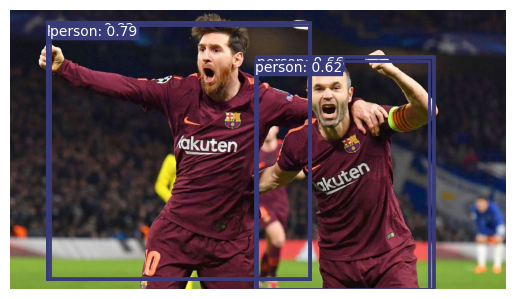

	+ Label: person | Confidence: 0.8117
	+ Label: person | Confidence: 0.6626
	+ Label: person | Confidence: 0.8153
	+ Label: person | Confidence: 0.6631
	+ Label: person | Confidence: 0.7870
	+ Label: person | Confidence: 0.6214


<Figure size 640x480 with 0 Axes>

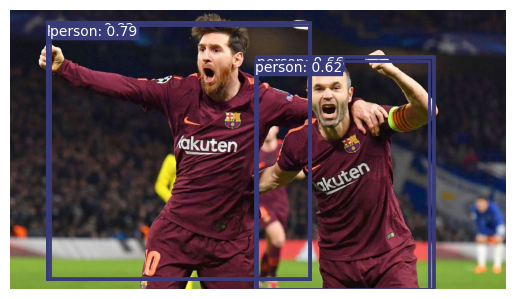

	+ Label: person | Confidence: 0.8117
	+ Label: person | Confidence: 0.6626
	+ Label: person | Confidence: 0.8153
	+ Label: person | Confidence: 0.6631
	+ Label: person | Confidence: 0.7870
	+ Label: person | Confidence: 0.6214


<Figure size 640x480 with 0 Axes>

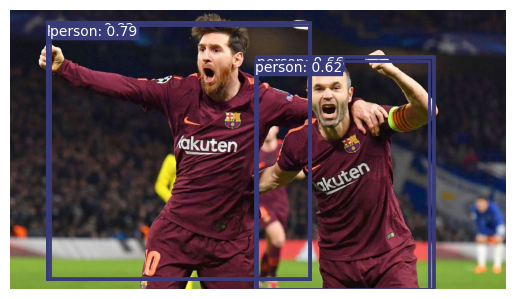

	+ Label: person | Confidence: 0.8117
	+ Label: person | Confidence: 0.6626
	+ Label: person | Confidence: 0.8153
	+ Label: person | Confidence: 0.6631
	+ Label: person | Confidence: 0.7870
	+ Label: person | Confidence: 0.6214


<Figure size 640x480 with 0 Axes>

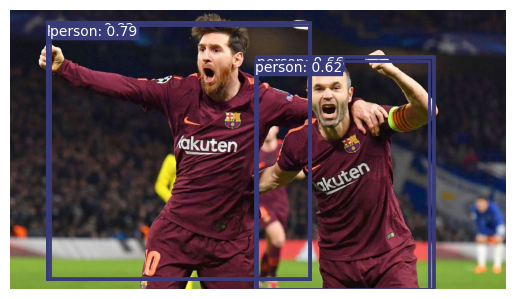

In [20]:
img = np.array(Image.open('..\data\samples\messi.jpg'))
for detect in boxes:
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Rescale boxes to original image
    detect = rescale_boxes(detect, img_size, img.shape[:2])
    unique_labels = detect[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_pred in detect:

        print(f"\t+ Label: {classes[int(cls_pred)]} | Confidence: {conf.item():0.4f}")

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=f"{classes[int(cls_pred)]}: {conf:.2f}",
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.show()